In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import cv2 #pip install opencv-python
from sklearn.metrics import confusion_matrix, f1_score
from scipy.optimize import minimize
import librosa                    
import librosa.display
from sklearn.preprocessing import normalize

In [3]:
IMG = './data/images_original/'
#IMG = './dataset/'
img_dataset = []
genre_target = []
genres = {}
i = 0
for root, dirs, files in os.walk(IMG):
    for name in files:
        filename = os.path.join(root, name)
        img_dataset.append(filename)
        genre = filename.split('\\')[0].split('/')[-1]
        genre_target.append(genre)
        
        if(genre not in genres):
            genres[genre] = i
            i+=1
print(genres)

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}


Initial shape: (288, 432)


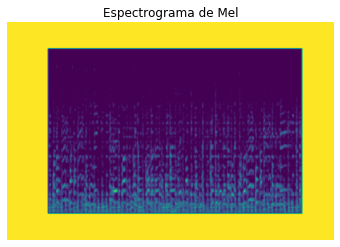

In [6]:
img = cv2.imread(img_dataset[0],0)
print("Initial shape:",img.shape)
plt.imshow(img, interpolation = 'bicubic', cmap='viridis')
plt.title("Espectrograma de Mel")
plt.axis('off')
plt.show()

In [5]:
def crop_borders(img,x1=35,x2=252,y1=54,y2=389):
    cropped = img[x1:x2,y1:y2]
    return cropped

In [ ]:
def get_y():
    '''Convierte los generos en un array de targets y'''
    y = []
    for genre in genre_target:
        #OneHot encoding?
        n = genres[genre]
        y.append(n)
    return np.array(y)

def get_x(shape=[999,217*335], flag=0):
    x = np.empty(shape, np.uint8)
    for i in range(len(img_dataset)):
        img = cv2.imread(img_dataset[i],flag)
        img = crop_borders(img)
        x[i] = img.ravel()
    return np.array(x)

In [ ]:
X = get_x()
y = get_y()
y = y.reshape(len(y),1)

In [ ]:
print(X.shape, y.shape)

In [ ]:
def show_sample_imgs(dataset, cmap='viridis', c=2, r=5):
    np.random.seed(5)
    fig=plt.figure(figsize=(15, 15))
    columns = c
    rows = r
    
    if(c == 2 and r == 5):
        sample = [i * 100 for i in range(len(genres))]
    else:
        sample = np.random.choice(len(img_dataset), columns*rows, 42)
    for i, j in zip(range(1, columns*rows +1),sample):
        fig.add_subplot(rows, columns, i)
        plt.title(genre_target[j])
        plt.imshow(dataset[j], cmap)
        plt.axis('off')
    plt.show()
    

show_sample_imgs(X.reshape([999,217,335]))

In [7]:
#Prueba de uso de valores del espectograma
def mel(file):
    '''devuelve un array con los valores del spectograma de mel de un fichero'''
    n_mels = 128
    hop_length = 1024
    n_fft = 2048

    file_location = file
    y, sr = librosa.load(file_location, duration = 30)
    #song,_ = librosa.effects.trim(y)
    song = y
    S = librosa.feature.melspectrogram(song, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    S_DB = librosa.power_to_db(S, ref=np.max)
    
    #Normalizar esto?
    #S_DB_ravel = S_DB.ravel()
    #normalized = normalize(S_DB_ravel[:,np.newaxis], axis=0, norm='l2').ravel()
    #normalized = np.reshape(normalized, S_DB.shape)
    
    #plt.figure(figsize=(432/80, 288/80), dpi=80)
    S_DB[S_DB < -40] = -40
    return S_DB.ravel()

def get_melX(shape):
    MUSIC = './data/genres_original'
    
    x = np.empty([999,shape], np.uint8)
    i = 0
    for root, dirs, files in os.walk(MUSIC):
        for name in files:
            filename = os.path.join(root, name)
            if(filename != "./data/genres_original\jazz\jazz.00054.wav"): #corrupted
                spectrum = mel(filename).ravel()
                if(len(spectrum) < shape):
                    #En caso de que una cancion dure menos de 30s rellenamos con 0s
                    padding = np.zeros(np.abs(len(spectrum)-shape))
                    spectrum = np.append(spectrum,padding)
                x[i] = spectrum
                i += 1
    return x

### Entrenamiento con regresión logística


In [ ]:
#funciones sigmoide, coste y gradiente de regresion logistica
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def cost(Theta, X, Y, Lambda):
    H = sigmoid(np.matmul(X, Theta))
    aux = (-1 / len(X)) * ( np.matmul(np.log(H).T, Y) + np.matmul(np.log(1-H).T, (1-Y)))
    regul = (Lambda/(2*len(X))) * np.sum(Theta**2)
    return (aux + regul)

def gradient(Theta, X, Y, Lambda):
    H = sigmoid(np.matmul(X, Theta))
    aux = np.matmul(X.T, H - Y) / len(X)
    regul = (Lambda/len(X)) * Theta
    return (aux + regul)